In [3]:
import pandas as pd

We first load in our annotated dataset, before separating users into groups based on labels.

In [6]:
num_topics = 100
data = pd.read_csv(f'data_with_{num_topics}.csv', sep='\t')

ParserError: Error tokenizing data. C error: Unknown error in IO callback

In [3]:
total = data
individual = data[(data['Account Type'] == 'individual') & (data['UserType'] != 'celebrity')]
organisational = data[(data['Account Type'] == 'organisational') & (data['UserType'] != 'business')]

In [4]:
business = data[data['UserType'] == 'business']
celebrity = data[data['UserType'] == 'celebrity']

In [5]:
influential = individual[individual['Twitter Followers'] >= 3018]
core_individual = individual[individual['Twitter Followers'] < 3018]

In [6]:
import matplotlib.pyplot as plt
import numpy as np

We then chart the monthly engagement rates for each user group.

In [13]:
def chart_engagement(df, name):
    bins = 61
    total = df
    xi = [10 * i for i in range(7)]
    x = ['05-15', '03-16', '01-17', '11-17', '09-18', '07-19','05-20']
    shares = df.loc[df['Thread Entry Type'] == 'share']
    posts = df.loc[df['Thread Entry Type'] == 'post']
    replies = df.loc[df['Thread Entry Type'] == 'reply']
    plt.title(f'{name} Engagement Type Counts by Month')
    share_counts = shares.Month.value_counts()
    share_data = np.array([share_counts.get(i, 0) for i in range(61)])
    plt.bar([_ for _ in range(61)], share_data, label='Shares')
    post_counts = posts.Month.value_counts()
    post_data = np.array([post_counts.get(i, 0) for i in range(61)])
    plt.bar([_ for _ in range(61)], post_data, bottom=share_data, label='Posts')
    reply_counts = replies.Month.value_counts()
    reply_data = np.array([reply_counts.get(i, 0) for i in range(61)])
    plt.bar([_ for _ in range(61)], reply_data, bottom=share_data + post_data, label='Replies')
    plt.xticks(xi, x)
    plt.xlabel('Date (Month-Year)')
    plt.ylabel('# of Engagements')
    plt.yscale('log', base=2)
    plt.axis([None, None, 0, 1000000])
    plt.legend()
    plt.show()

<ipython-input-13-60d4f45542ac>:23: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.axis([None, None, 0, 1000000])


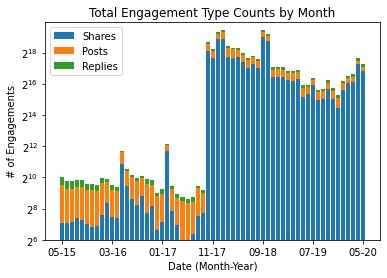

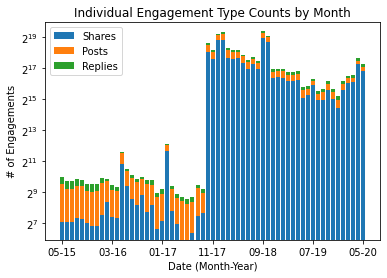

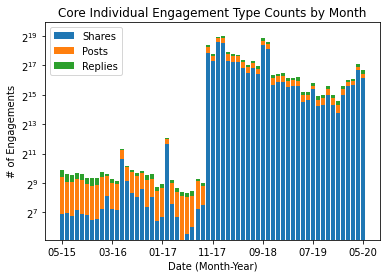

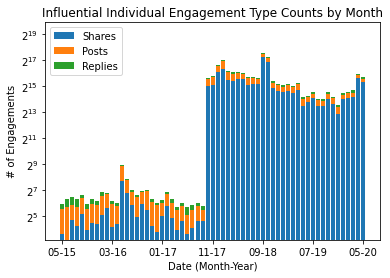

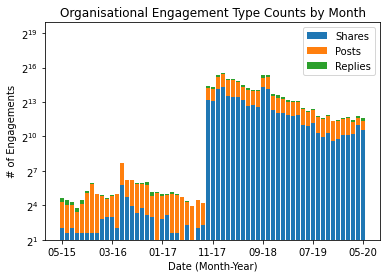

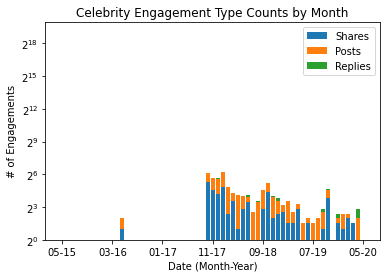

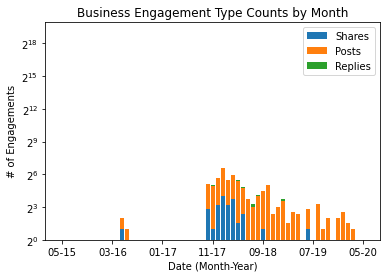

In [14]:
chart_engagement(data, 'Total')
chart_engagement(individual, 'Individual')
chart_engagement(core_individual, 'Core Individual')
chart_engagement(influential, 'Influential Individual')
chart_engagement(organisational, 'Organisational')
chart_engagement(celebrity, 'Celebrity')
chart_engagement(business, 'Business')

In [15]:
male = individual[individual['gender_inferred'] == 'male']
female = individual[individual['gender_inferred'] == 'female']

<ipython-input-13-60d4f45542ac>:23: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.axis([None, None, 0, 1000000])


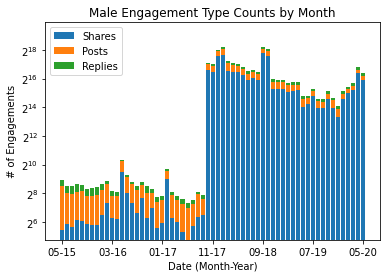

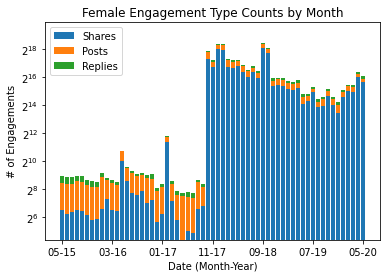

In [16]:
chart_engagement(male, 'Male')
chart_engagement(female, 'Female')

In [17]:
ethnicities = pd.unique(individual.Ethnicity.values).tolist()
ethnicities = ethnicities[2:]

<ipython-input-13-60d4f45542ac>:23: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.axis([None, None, 0, 1000000])


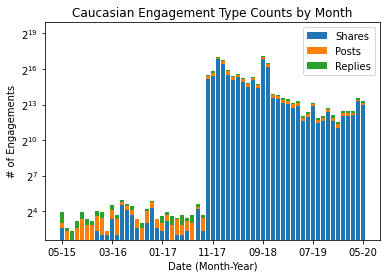

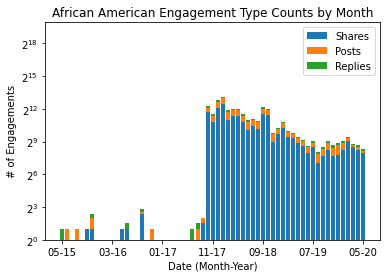

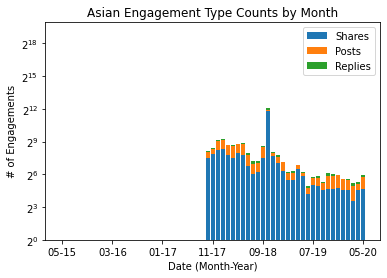

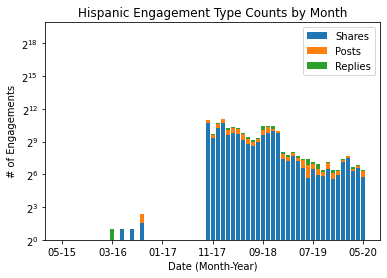

In [18]:
for eth in ethnicities:
    chart_engagement(core_individual[core_individual['Ethnicity'] == eth], eth)

In [19]:
genders = ['Male', 'Female']

<ipython-input-13-60d4f45542ac>:23: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.axis([None, None, 0, 1000000])


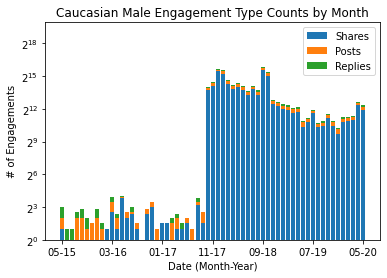

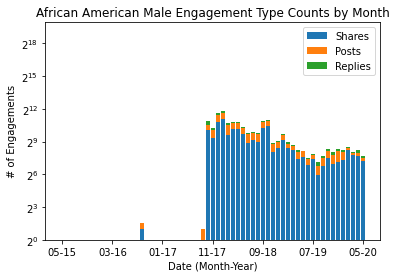

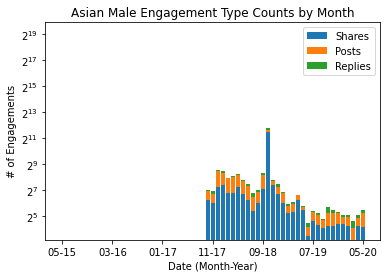

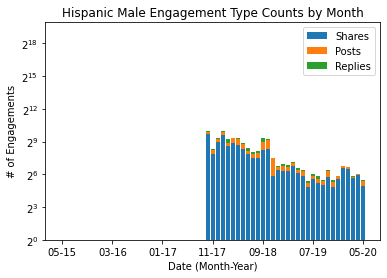

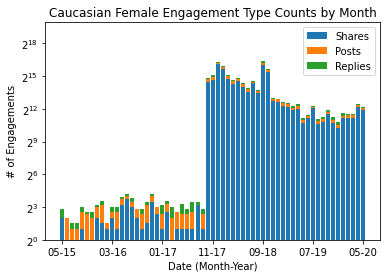

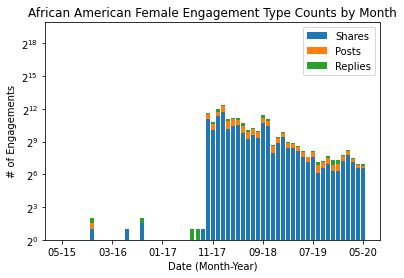

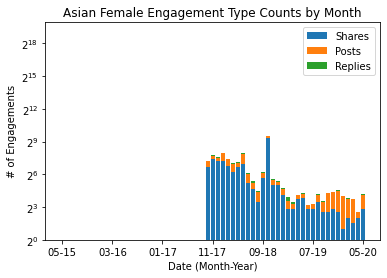

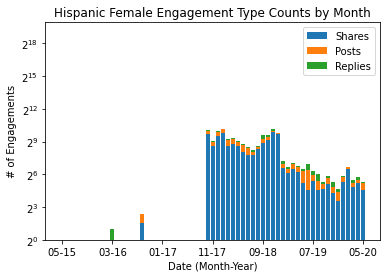

In [20]:
for g in genders:
    for eth in ethnicities:
        temp = core_individual[(core_individual['gender_inferred'] == g.lower()) & (core_individual['Ethnicity'] == eth)]
        chart_engagement(temp, f'{eth} {g}')

Next we chart the proportions of engagement types (share, post, reply) to compare various user groups.

In [32]:
def chart_engagement_proportions(series, names, title, logy=False):
    x = np.arange(3)
    plt.title(f'Engagement Type Proportions by {title}')
    x_labels = ['Shares', 'Posts', 'Replies']
    offset = .5 / len(series) 
    for i, df in enumerate(series):
        data = df['Thread Entry Type'].value_counts()
        split = names[i].split()
        label = names[i] if len(split) < 3 else ' '.join(split[:2]) + '\n' + ' '.join(split[2:])
        data = np.array([data['share'], data['post'], data['reply']]) / sum([data['share'], data['post'], data['reply']])
        plt.bar(x + offset * i, data, label = label, width=offset)
    plt.legend()
    plt.xticks(x + (offset/2 * (len(series) - 1)), x_labels)
    plt.xlabel('Engagement Type')
    plt.ylabel('% of Engagements')
    plt.ylim(0,1)
    plt.plot()
    
    

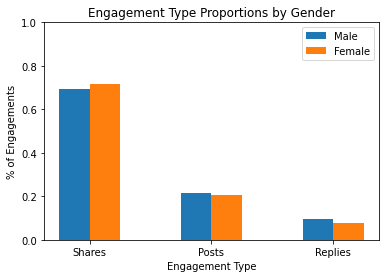

In [33]:
chart_engagement_proportions([male, female], ['Male', 'Female'], 'Gender')

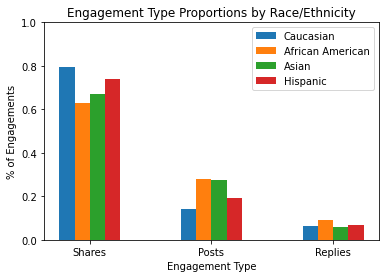

In [34]:
chart_engagement_proportions([individual[individual['Ethnicity'] == eth] for eth in ethnicities], ethnicities, 'Race/Ethnicity')

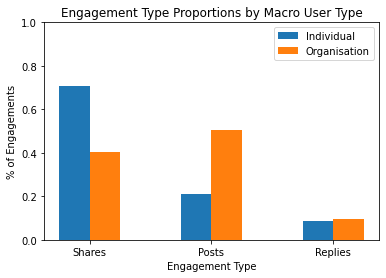

In [35]:
chart_engagement_proportions([individual, organisational], ["Individual", "Organisation"], 'Macro User Type')

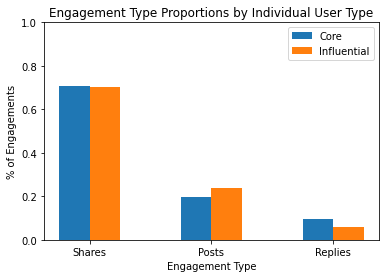

In [36]:
chart_engagement_proportions([core_individual, influential], ["Core", "Influential"], 'Individual User Type')

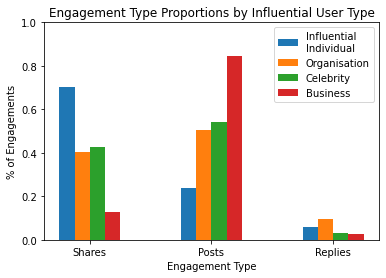

In [37]:
chart_engagement_proportions([influential, organisational, celebrity, business], ["Influential\nIndividual", "Organisation", "Celebrity", "Business"], 'Influential User Type')

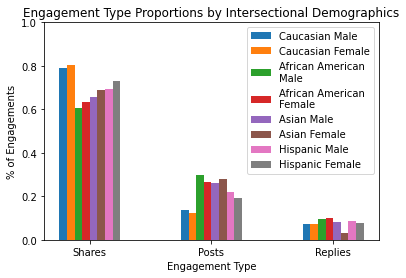

In [38]:
intersectional_groups = []
names = []
ethnicity_frames = []
for eth in ethnicities:
    ethnicity_frames.append(core_individual[core_individual['Ethnicity'] == eth])
    for g in genders:
        intersectional_groups.append(core_individual[(core_individual['gender_inferred'] == g.lower()) & (core_individual['Ethnicity'] == eth)])
        names.append(f'{eth} {g}')
chart_engagement_proportions(intersectional_groups, names, 'Intersectional Demographics')

We then generate a table with summary statistics for all of our user groups.

In [39]:
groups = ['Total', 'Core Individual', 'Influential Individual', 'Organisational', 'Celebrity', 'Business']
groups += genders
groups += ethnicities
groups += names
frames = [data, core_individual, influential, organisational, celebrity, business, male, female] + ethnicity_frames + intersectional_groups


In [40]:
group_summaries = pd.DataFrame({'Group': [], 'Unique Authors': [], 'Engagements': [], 'Posts': [], 'Shares': [], 'Replies': [], 'Avg Followers': [], 'Avg Following': [], 'Avg Impressions': []})
group_summaries['Group'] = groups
group_summaries['Avg Impressions'] = [round(f['Impressions'].mean()) for f in frames]
counts, posts, shares, replies, followers, following = [], [], [], [], [], []
for frame in frames:
    post_type_counts = frame['Thread Entry Type'].value_counts()
    posts.append(post_type_counts['post'])
    shares.append(post_type_counts['share'])
    replies.append(post_type_counts['reply'])
    counts.append(len(pd.unique(frame.Author)))
    grouped = frame.groupby('Author')
    following.append(round(grouped['Twitter Following'].mean().mean()))
    followers.append(round(grouped['Twitter Followers'].mean().mean()))

group_summaries['Unique Authors'] = counts
group_summaries['Engagements'] = [len(frame) for frame in frames]
group_summaries['Posts'] = posts
group_summaries['Shares'] = shares
group_summaries['Replies'] = replies
group_summaries['Avg Followers'] = followers
group_summaries['Avg Following'] = following
group_summaries
    


Group  Unique Authors  Engagements    Posts   Shares  \
0                     Total         1385104      7173427  1646893  4907414   
1           Core Individual         1242537      4967587   989191  3508998   
2    Influential Individual          137993      1707647   406836  1197927   
3            Organisational           44905       497549   250497   200233   
4                 Celebrity              35          567      306      243   
5                  Business              45          574      486       74   
6                      Male          666836      3158664   678594  2184809   
7                    Female          699880      3516570   717433  2522116   
8                 Caucasian           48029      1028338   133340   820203   
9          African American            5726        66184    18507    41148   
10                    Asian             694        10275     2745     6844   
11                 Hispanic            1979        20983     4289    14983   
12           Caucasian Male           22596       438196    59495   346194   
13         Caucasian Female           27000       590142    73845   474009   
14    African American Male            2464        29436     8751    17875   
15  African American Female            3530        36748     9756    23273   
16               Asian Male             391         7474     1964     4910   
17             Asian Female             318         2801      781     1934   
18            Hispanic Male             914         9143     2012     6331   
19          Hispanic Female            1133        11840     2277     8652   

    Replies  Avg Followers  Avg Following  Avg Impressions  
0    619120           3356           1220            19134  
1    469398            489            732             1441  
2    102884          22517           6040            40005  
3     46819          21789           1771           119117  
4        18        7722851           8496          5322239  
5        14        5941736          14776         11209884  
6    295261           3103           1314            11275  
7    277021           2264           1133            11334  
8     74795            883           1322             1443  
9      6529            703            716             1668  
10      686            690            698             1319  
11     1711            574            556             1427  
12    32507            889           1353             1452  
13    42288            881           1303             1436  
14     2810            733            734             1501  
15     3719            694            706             1803  
16      600            688            713             1275  
17       86            703            701             1437  
18      800            603            613              986  
19      911            560            518             1767

In [41]:
total_topics = {}

for i, frame in enumerate(frames):
    topic_dist = [frame[str(j)].mean() for j in range(num_topics)]
    total_topics[groups[i]] = {'dist': topic_dist}
    

In [42]:
import torch

In [43]:
import json

Here we load in our topic words, calculate PMI for each topic, group pair, and store the top 5 most prescient topics for each group along with their top 5 key words in a table.

In [44]:
with open(f'{num_topics}-topic-words.json') as f:
    topic_words = json.load(f)

In [45]:
def calc_pmi(x, frame, group, dists):
    prob_x_and_frame = dists[group]['dist'][x]
    prob_x = dists['Total']['dist'][x]
    prob_frame = len(frame) / len(data)
    return np.log(prob_x_and_frame / (prob_x * prob_frame))

In [46]:
for i, frame in enumerate(frames):
    total_topics[groups[i]]['pmis'] = np.nan_to_num([calc_pmi(topic, frame, groups[i], total_topics) for topic in range(100)], nan=0.0)

<ipython-input-45-9ffd0c86a2be>:5: RuntimeWarning: invalid value encountered in double_scalars
  return np.log(prob_x_and_frame / (prob_x * prob_frame))


In [47]:
for group in groups:
        total_topics[group]['pmi-top5'] = torch.topk(torch.tensor(total_topics[group]['pmis']), 5).indices

group_names = []
top_t_topics = []
key_words = []

for group in groups[1:]:
    for topic in total_topics[group]['pmi-top5']:
        group_names.append(group)
        top_t_topics.append(int(topic))
        key_words.append(' '.join(topic_words[str(int(topic))][:5]))
pmi_df = pd.DataFrame({'Group': group_names, 'Top 5 Topics': top_t_topics, 'Key Words': key_words})
pmi_df.to_csv('pmi_topics.csv', index=False)
pmi_df


Group  Top 5 Topics                                   Key Words
0   Core Individual            31                       im may lot started ok
1   Core Individual            32      sexually every assaulted without women
2   Core Individual            79           assault sexual speak someone male
3   Core Individual             1                right white let mean talking
4   Core Individual            42  want survivors survivor hashtag especially
..              ...           ...                                         ...
90  Hispanic Female            64             victims news pain timesup trust
91  Hispanic Female            94             thank black girls happens women
92  Hispanic Female            76       tonight created equal walk patriarchy
93  Hispanic Female            48             lives feminists wave women rage
94  Hispanic Female            98                 please look th pm treatment

[95 rows x 3 columns]

Here we calculate the pearson correlation coefficient over the monthly engagement series for each influential, non-influential group pair.

In [48]:
def calculate_engagement_correlations(standards, dfs, std_names, names):
    corr_df = pd.DataFrame({'Group': names})
    for i, standard in enumerate(standards):
        standard_series = [len(standard[standard['Month'] == j]) for j in range(61)]
        corrs = []
        for df in dfs:
            df_series = [len(df[df['Month'] == j]) for j in range(61)]
            corrs.append(np.corrcoef(standard_series, df_series)[0,1])
        corr_df[std_names[i]] = corrs
    return corr_df
        
    
        

In [49]:
eng_corr = calculate_engagement_correlations([influential, organisational, celebrity, business], [core_individual, male, female] + ethnicity_frames + intersectional_groups, ['Influential Individual', 'Organisational', 'Celebrity', 'Business'], ['Core Individual', 'Male', 'Female'] + ethnicities + names)

In [50]:
eng_corr

Group  Influential Individual  Organisational  \
0           Core Individual                0.934682        0.955098   
1                      Male                0.975191        0.957438   
2                    Female                0.944657        0.954019   
3                 Caucasian                0.928007        0.942389   
4          African American                0.840794        0.956270   
5                     Asian                0.619389        0.582359   
6                  Hispanic                0.816051        0.924983   
7            Caucasian Male                0.944858        0.950432   
8          Caucasian Female                0.913726        0.934307   
9     African American Male                0.856497        0.965084   
10  African American Female                0.825742        0.945692   
11               Asian Male                0.583742        0.530606   
12             Asian Female                0.715849        0.747388   
13            Hispanic Male                0.814335        0.929150   
14          Hispanic Female                0.767424        0.865101   

    Celebrity  Business  
0    0.869532  0.853020  
1    0.813442  0.821979  
2    0.858354  0.834844  
3    0.784767  0.801646  
4    0.893338  0.943054  
5    0.435797  0.408458  
6    0.889798  0.868622  
7    0.773958  0.802040  
8    0.790431  0.799336  
9    0.878863  0.935588  
10   0.899876  0.944305  
11   0.373361  0.344121  
12   0.655921  0.638484  
13   0.887076  0.912895  
14   0.837439  0.780938

Finally we calculate the pearson correlation coefficient over the monthly topic importance seires for each influential, non-influential group pair for 4 representative topics.

In [51]:
def calculate_topic_correlations(standards, dfs, col_names, names, topic):
    corr_df = pd.DataFrame({'Group': names})
    for i, standard in enumerate(standards):
        standard_series = [standard[standard['Month'] == j][str(topic)].mean() if len(standard[standard['Month'] == j]) > 0 else 0.0 for j in range(61)]
        corrs = []
        for df in dfs:
            df_series = [df[df['Month'] == j][str(topic)].mean() if len(df[df['Month'] == j]) > 0 else 0.0 for j in range(61)]
            corrs.append(np.corrcoef(standard_series, df_series)[0,1])
        corr_df[col_names[i]] = corrs
    return corr_df
        

In [52]:
topic_4_cors = calculate_topic_correlations([influential, organisational, celebrity, business], [core_individual, male, female] + ethnicity_frames + intersectional_groups, ['Influential Individual', 'Organisational', 'Celebrity', 'Business'], ['Core Individual', 'Male', 'Female'] + ethnicities + names, 4)
topic_64_cors = calculate_topic_correlations([influential, organisational, celebrity, business], [core_individual, male, female] + ethnicity_frames + intersectional_groups, ['Influential Individual', 'Organisational', 'Celebrity', 'Business'], ['Core Individual', 'Male', 'Female'] + ethnicities + names, 64)
topic_94_cors = calculate_topic_correlations([influential, organisational, celebrity, business], [core_individual, male, female] + ethnicity_frames + intersectional_groups, ['Influential Individual', 'Organisational', 'Celebrity', 'Business'], ['Core Individual', 'Male', 'Female'] + ethnicities + names, 94)
topic_81_cors = calculate_topic_correlations([influential, organisational, celebrity, business], [core_individual, male, female] + ethnicity_frames + intersectional_groups, ['Influential Individual', 'Organisational', 'Celebrity', 'Business'], ['Core Individual', 'Male', 'Female'] + ethnicities + names, 81)

In [53]:
topic_4_cors

Group  Influential Individual  Organisational  \
0           Core Individual                0.912626        0.811354   
1                      Male                0.935156        0.798037   
2                    Female                0.922922        0.830203   
3                 Caucasian                0.560541        0.663539   
4          African American                0.191483        0.213613   
5                     Asian                0.698814        0.693500   
6                  Hispanic                0.791703        0.783412   
7            Caucasian Male                0.451083        0.575101   
8          Caucasian Female                0.662950        0.700723   
9     African American Male                0.766307        0.762540   
10  African American Female                0.201665        0.219550   
11               Asian Male                0.743933        0.699001   
12             Asian Female                0.446380        0.510338   
13            Hispanic Male                0.716038        0.715029   
14          Hispanic Female                0.764227        0.732879   

    Celebrity  Business  
0    0.487898  0.502994  
1    0.461094  0.503198  
2    0.499014  0.510048  
3    0.248494  0.243079  
4    0.103581  0.123665  
5    0.580293  0.461551  
6    0.450494  0.605380  
7    0.155104  0.178731  
8    0.348489  0.305860  
9    0.534162  0.530206  
10   0.087053  0.111545  
11   0.476995  0.522392  
12   0.607721  0.201165  
13   0.465871  0.407885  
14   0.410816  0.653350

In [54]:
topic_64_cors

Group  Influential Individual  Organisational  \
0           Core Individual                0.759439        0.756855   
1                      Male                0.811095        0.760412   
2                    Female                0.791380        0.765272   
3                 Caucasian                0.536449        0.511594   
4          African American                0.658373        0.731780   
5                     Asian                0.555613        0.685473   
6                  Hispanic                0.411829        0.480392   
7            Caucasian Male                0.245432        0.223010   
8          Caucasian Female                0.531720        0.625217   
9     African American Male                0.580601        0.689557   
10  African American Female                0.660431        0.679840   
11               Asian Male                0.579534        0.627342   
12             Asian Female                0.466471        0.632657   
13            Hispanic Male                0.652897        0.725468   
14          Hispanic Female                0.324660        0.369506   

    Celebrity  Business  
0    0.507525  0.255230  
1    0.526869  0.266306  
2    0.496314  0.253629  
3    0.366695  0.194636  
4    0.465678  0.322936  
5    0.190971  0.279250  
6    0.369998  0.357533  
7    0.146498  0.076382  
8    0.470492  0.251014  
9    0.390186  0.317530  
10   0.487559  0.285660  
11   0.364245  0.317131  
12   0.099170  0.216208  
13   0.451489  0.319274  
14   0.335461  0.361193

In [55]:
topic_94_cors

Group  Influential Individual  Organisational  \
0           Core Individual                0.664831       -0.078829   
1                      Male                0.631076        0.108700   
2                    Female                0.740375       -0.128178   
3                 Caucasian                0.395505       -0.163146   
4          African American                0.539068       -0.198319   
5                     Asian               -0.148316       -0.198990   
6                  Hispanic                0.526887       -0.198202   
7            Caucasian Male               -0.159495       -0.225423   
8          Caucasian Female                0.371214       -0.096305   
9     African American Male               -0.193021       -0.212350   
10  African American Female                0.617048       -0.160618   
11               Asian Male               -0.153507       -0.197264   
12             Asian Female               -0.066286       -0.128365   
13            Hispanic Male               -0.163773       -0.237780   
14          Hispanic Female                0.483138       -0.198796   

    Celebrity  Business  
0    0.077179 -0.056539  
1    0.081308 -0.049398  
2    0.028331 -0.054943  
3    0.009341 -0.030094  
4    0.160708  0.033627  
5    0.431143  0.110531  
6    0.148326  0.183196  
7    0.117472  0.043215  
8   -0.010301 -0.039447  
9    0.457421  0.119041  
10   0.057544  0.008905  
11   0.368087  0.119901  
12   0.474565  0.056670  
13   0.353689  0.209054  
14   0.180730  0.218504

In [56]:
topic_81_cors

Group  Influential Individual  Organisational  \
0           Core Individual                0.642321        0.393716   
1                      Male                0.793460        0.431566   
2                    Female                0.675688        0.390305   
3                 Caucasian                0.486476        0.302422   
4          African American               -0.068916        0.102362   
5                     Asian                0.309029        0.292688   
6                  Hispanic                0.066761        0.031219   
7            Caucasian Male                0.103144        0.246560   
8          Caucasian Female                0.716171        0.254919   
9     African American Male                0.394315        0.317070   
10  African American Female               -0.070290        0.098207   
11               Asian Male                0.321776        0.294342   
12             Asian Female                0.090668        0.146389   
13            Hispanic Male                0.324177        0.255487   
14          Hispanic Female                0.071372        0.039111   

    Celebrity  Business  
0    0.037980  0.001260  
1    0.162968  0.037680  
2    0.037192  0.005032  
3    0.075824  0.047843  
4    0.008602 -0.005060  
5    0.008428  0.013962  
6    0.017726  0.000759  
7    0.024237  0.018079  
8    0.131251  0.080470  
9    0.206928  0.175767  
10   0.013816 -0.012425  
11   0.007100  0.036429  
12   0.034488 -0.014225  
13   0.239975  0.117779  
14   0.005426  0.001795